In [1]:
from pydens import Solver, NumpySampler, D, V, ConvBlockModel
import numpy as np
import torch
import matplotlib.pyplot as plt
from pydens import NumpySampler as NS
from mpl_toolkits.mplot3d import Axes3D

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_loss(loss):
    plt.plot(loss)
    plt.grid()
    plt.xlabel('ITERATION', fontsize=16)
    plt.ylabel('L1-loss', fontsize=16)

In [3]:
def plot_approximation_1d(points, approximation, solution_function, savepath=None,
                          title=None, ylim=None):
    if isinstance(points, torch.Tensor):
        points = points.detach().numpy()
    if isinstance(approximation, torch.Tensor):
        approximation = approximation.detach().numpy()

    plt.plot(points, approximation, label='Neural Network approximation',
             linewidth=5, alpha=0.8)
    plt.plot(points, solution_function(points), label='Known analytical solution',
             linewidth=2)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$\hat{f}(x)$', fontsize=16)
    plt.grid()
    plt.legend(fontsize=12, loc=1)

    if ylim is not None:
        plt.ylim(ylim)

    if title is not None:
      plt.title(title, fontsize=16)

    if savepath is not None:
        plt.savefig(savepath, dpi=300)

def plot_approximation_2d(approximation):
    plt.imshow(approximation)
    plt.colorbar()
    plt.title(r'$\hat{f}(x, y)$', fontsize=16)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$y$', fontsize=16)

def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

### Poisson equation

100%|██████████| 300/300 [00:00<00:00, 322.12it/s]


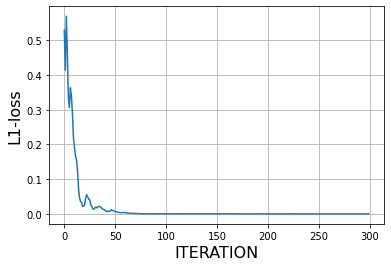

In [4]:
# Set up the partial differential equation problem
def pde(f, x):
    return D(D(f, x), x)- torch.cos(np.pi * (2*x))

solver1 = Solver(pde, ndims=1, boundary_condition=0,
                model=ConvBlockModel,
                layout='fafaf', units=[10, 10, 1], activation='Tanh')

solver1.fit(niters=300, batch_size=400, lr=0.02)

plot_loss(solver1.losses[:])
plt.savefig('poisson1_loss.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


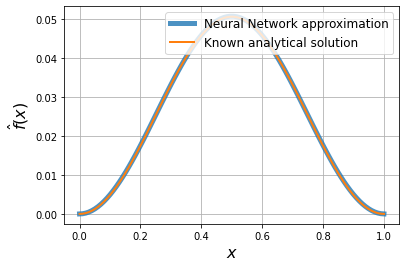

In [5]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
fs = solver1.predict(xs)

plot_approximation_1d(xs, fs, lambda x: (1/ (2* np.pi**2))*((np.sin(np.pi * x))**2))
plt.savefig('poisson1.eps', format='eps')

2d Poisson PDE 

In [6]:
def pde(f, x, y):
    return D(D(f, x), x) + D(D(f, y), y) - 5 * torch.sin(np.pi * (x + y))

solver2 = Solver(pde, ndims=2, boundary_condition=0,
                model=ConvBlockModel,
                layout='fafaf', units=[10, 10, 1], activation='Tanh')

solver2.fit(niters=300, batch_size=400, lr=0.02)            

100%|██████████| 300/300 [00:01<00:00, 200.55it/s]


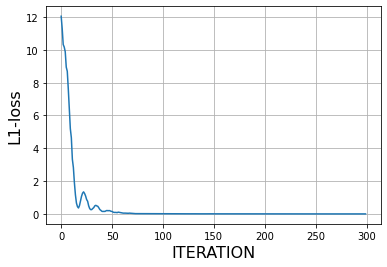

In [7]:
plot_loss(solver2.losses[:])
plt.savefig('poisson2_loss.eps', format='eps')

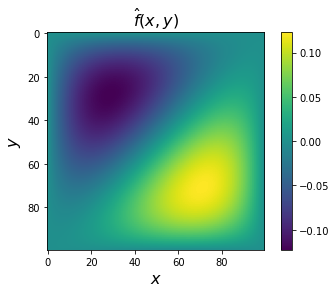

In [8]:
grid = cart_prod(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
approxs = solver2.predict(grid[:, 0:1], grid[:, 1:2]).reshape((100, 100))
plot_approximation_2d(approxs)
plt.savefig('poisson2.eps', format='eps')

Inverse Probelm Using Neural Network